# Capstone Project - 
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

There are many Strat up businesses which fails or comes to a halt due to lack of right decision in the initial period of business, that have been said not all business glooms at any location u pick up even if u have all the capital needed to boost start the business, in India many businesses fails due to this reasons Top 10 Reason of Restaurant fail and many other reason as well but here we will focus on location based guidance .

we will find out the most common venues people of the particular area opt for as number of common venues is directly propotional to the most visited places by the customers.

Obviously if an investor is willing to invest a hefty amount of capital in a business, then will be more interested to invest it where ROI is high and invest their money with assurance that the business will have a good start because of the location selected.

we will use our Data science powers to find out which business,one should invest in and where.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of most common venue in the neighborhood (any type of buisness)
* Area of the city
* Geolocation of the area

Following data sources will be needed to extract/generate the required information:

* As this project focuses on India so the Dataset is for Indian region, we took a small part of India with the highest GDP, The Mumbai City. 
* To grab the Area (aka Neighborhood) of Mumbai city, we scrapped a Website ethically containing all the area of Mumbai city using Beautiful Soup.
* As we have the Area name of Mumbai city we will need the geolocation of the same, so we use arcgis API to extract latitude and longitude of the area in Mumbai city and later map it on to the map of India.
* We have area name, latitude & longitude of the area, now to grab all the top and most common businesses we use foursquare API and use its category column to give us best businesses to bet our money upon in 6 different clusters which we will make by the end of the project.


## Methodology <a name="methodology"></a>

As this project focuses on India so the Dataset is for Indian region, we took a small part of India with the highest GDP, The Mumbai City.

Here we used Beautifulsoup to scrape the data from website which contains Mumbai Neighborhoods (we will call it Area).

futher we Saved the DataFrame to use it for futher operations

### 1. Web Scraping

First we Scrape the Website by BeautifulSoup() Function which gave us the Html content of the site and later we saw the hierarchy of class and div to sort out the list of content

In [83]:
# Importing Libraries for Web Scrapping
import pandas as pd
import requests
# import csv
from bs4 import BeautifulSoup

The below code is for scrapping the wikipedia site which contains mumbai Neighborhoods aka AREA

In [84]:
url = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai"
page = requests.get(url).text
soup = BeautifulSoup(page,"html.parser")
div = soup.find_all(class_="toctext")
places = []
for place in div:
    places.append(place.contents[0])
places = [x.strip() for x in places]

In [85]:
area_df_wiki= pd.DataFrame(places,columns=["Area"])

print(area_df_wiki.shape)

(45, 1)


In [4]:
area_df_wiki.head()

,Area
0,Western Suburbs
1,Andheri
2,Bhayandar
3,Bandra
4,Borivali


Removing few Outliers and few area  which are actually not a part of Mumbai,Still I have kept one Area which is Definatly not a part of mumbai to check wheather our cluster finds it out or not 

#####  P.S: It's Bhayander at index 1

In [5]:
area_df_wiki.drop(index=[0,14,15,17,26,31,43,44],inplace=True) #droping invalid rows
area_df_wiki.reset_index(drop=True,inplace=True)

In [6]:
print(area_df_wiki.shape)
area_df_wiki.head()

(37, 1)


,Area
0,Andheri
1,Bhayandar
2,Bandra
3,Borivali
4,Dahisar


It's Always a Good Idea to save Your Csv before moving to next Phase of coding

In [7]:
area_df_wiki.to_csv("area_df_wiki.csv")

### 2.Extracting Geocode Location

As we have the Area name of Mumbai city we will need the geolocation of the same, so we use arcgis API to extract latitude and longitude of the area in Mumbai city and later map it on to the map of India.

I have Used Arcgis API as it doesnt use any API key and is an open source

In [8]:
# Importing Files to extract Geocodes of area using arcgis API
import pandas as pd
import numpy as np
import geocoder #for extracting lat lng of AREA
import requests
from geopy.geocoders import Nominatim# for mumbai Lat lng


In [9]:
area_df = pd.read_csv("area_df_wiki.csv",index_col=0)

The Below code will generate lat and lng of the area

* Created two list for latitude and longitude respectively
* geocoder takes argument address where address should be in "area name, Mumbai" Format
* later we append the object attribute g.latlng to the list we creater earlier 
* futhermore we then join the original df with the lat long we got 

In [10]:
lt=[]
ln=[]
for address in area_df["Area"]:
    ads = f"{address},Mumbai"
    g = geocoder.arcgis(ads)
    lt.append(g.latlng[0])
    ln.append(g.latlng[1])

In [11]:
print(len(lt),",",len(ln)) #length of the lat and long we extracted
lat_lng=pd.DataFrame(list(zip(lt,ln)),columns=["Latitude","Longitude"])
area_df=area_df.join(lat_lng)

37 , 37


In [12]:
area_df.head()

,Area,Latitude,Longitude
0,Andheri,19.118459,72.841763
1,Bhayandar,19.307430,72.851840
2,Bandra,19.054370,72.840170
3,Borivali,19.229360,72.857510
4,Dahisar,19.250030,72.859070


In [13]:
area_df.to_csv("area_df_with_latlng.csv")

## Analysis <a name="analysis"></a>

We have area name, latitude & longitude of the area, now to grab all the top and most common businesses we use foursquare API and use its category column to give us best businesses to bet our money upon in 6 different clusters which we will make by the end of the project.

We will make a map to map all the location we grabed to see visually where this lie upon

In [14]:
# importing to cluster and nake our model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import geocoder
import folium
import json
from pandas.io.json import json_normalize
import requests
from geopy.geocoders import Nominatim
import matplotlib.colors as colors
import matplotlib.cm as cm

In [15]:
mumbai_df = pd.read_csv("area_df_with_latlng.csv",index_col=0)
mumbai_df.head()

,Area,Latitude,Longitude
0,Andheri,19.118459,72.841763
1,Bhayandar,19.307430,72.851840
2,Bandra,19.054370,72.840170
3,Borivali,19.229360,72.857510
4,Dahisar,19.250030,72.859070


In [16]:
print(f"{mumbai_df.shape}")

(37, 3)


The below code will generate mumbai lat and lng


In [17]:
geolocator = Nominatim(user_agent="a",timeout=10)
location = geolocator.geocode("India,Mumbai")
mum_lat= location.latitude
mum_lng=location.longitude
print(f"Mumbai lat is {mum_lat} and lng {mum_lng}")

Mumbai lat is 18.9387711 and lng 72.8353355


### Folium Map
Map of all Area in Mumbai

In [18]:
#creating folium map

map_mumbai = folium.Map(location=[mum_lat,mum_lng],zoom_start=12)
# map_mumbai

for lat,lng,area in zip(mumbai_df["Latitude"],
                       mumbai_df["Longitude"],
                       mumbai_df["Area"]):
    label = f"{area}"
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(location=[lat,lng],radius=5,color="red",popup=label,fill=True,fill_color="Blue",fill_opacity=0.8,parse_html=False).add_to(map_mumbai)
    
map_mumbai

### FourSquare API to Extract Venues
Now we will extract Venues by using this API
* Define variable for parameters
* Create a get request from a url and convert it into json
* Extract and analyse key of response
* Then we Convert Json to dataframe


In [19]:
CLIENT_ID = 'YAXPUG5FDSDEY44BIZ0S3WFLS5TB0NEVUMFY2EW0LWGXK2QY'
CLIENT_SECRET = 'AF2D4DEYTAVXRYMRU0TFMVYD1GVHR3U2MBHTGCAXU5SCNNZR' 
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YAXPUG5FDSDEY44BIZ0S3WFLS5TB0NEVUMFY2EW0LWGXK2QY
CLIENT_SECRET:AF2D4DEYTAVXRYMRU0TFMVYD1GVHR3U2MBHTGCAXU5SCNNZR


In [20]:
LIMIT = 150# limit of number of venues returned by Foursquare API

radius = 8000 # define radius 8k because its almost 16 km spread
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    mumbai_df.loc[5,"Latitude"], 
    mumbai_df.loc[5,"Longitude"], 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=YAXPUG5FDSDEY44BIZ0S3WFLS5TB0NEVUMFY2EW0LWGXK2QY&client_secret=AF2D4DEYTAVXRYMRU0TFMVYD1GVHR3U2MBHTGCAXU5SCNNZR&v=20180605&ll=19.16455000000008,72.84946000000008&radius=8000&limit=150'

In [21]:
r = requests.get(url).json()

In [22]:
r["response"]["groups"][0]["items"]

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4cbc55c37a5d9eb0ac5c31e9',
   'name': 'The Westin Mumbai Garden City',
   'location': {'address': 'International Business Park, Oberoi Garden City',
    'crossStreet': 'Off Western Express Highway',
    'lat': 19.172654033012886,
    'lng': 72.86051818993221,
    'labeledLatLngs': [{'label': 'display',
      'lat': 19.172654033012886,
      'lng': 72.86051818993221}],
    'distance': 1471,
    'postalCode': '400063',
    'cc': 'IN',
    'city': 'Mumbai',
    'state': 'Mahārāshtra',
    'country': 'India',
    'formattedAddress': ['International Business Park, Oberoi Garden City (Off Western Express Highway)',
     'Mumbai 400063',
     'Mahārāshtra',
     'India']},
   'categories': [{'id': '4bf58dd8d48988d1fa931735',
     'name': 'Hotel',
     'pluralName': 'Hotels',
     'shortName': 'Hotel',
     'icon': {'prefix': 'ht

In [23]:
venue=r["response"]["groups"][0]["items"]
venue_df =json_normalize(venue)

In [24]:
venue_df.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,...,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.venuePage.id,venue.location.neighborhood
0,e-0-4cbc55c37a5d9eb0ac5c31e9-0,0,"[{'summary': 'This spot is popular', 'type': '...",4cbc55c37a5d9eb0ac5c31e9,The Westin Mumbai Garden City,"International Business Park, Oberoi Garden City",Off Western Express Highway,19.172654,72.860518,"[{'label': 'display', 'lat': 19.17265403301288...",...,IN,Mumbai,Mahārāshtra,India,"[International Business Park, Oberoi Garden Ci...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",0,[],NaN,NaN
1,e-0-4e7b4508aeb70c2b1be28e00-1,0,"[{'summary': 'This spot is popular', 'type': '...",4e7b4508aeb70c2b1be28e00,Sapre,Aarey Rd,off Goregaon Subway,19.166621,72.847547,"[{'label': 'display', 'lat': 19.16662147339827...",...,IN,Mumbai,Mahārāshtra,India,"[Aarey Rd (off Goregaon Subway), Mumbai 400062...","[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",0,[],NaN,NaN
2,e-0-4bf7c3695efe2d7fef796934-2,0,"[{'summary': 'This spot is popular', 'type': '...",4bf7c3695efe2d7fef796934,PVR Cinemas,"Oberoi Mall, Off Western Express Highway",Goregaon (East),19.174016,72.860485,"[{'label': 'display', 'lat': 19.17401554630320...",...,IN,Mumbai,Mahārāshtra,India,"[Oberoi Mall, Off Western Express Highway (Gor...","[{'id': '4bf58dd8d48988d180941735', 'name': 'M...",0,[],NaN,NaN
3,e-0-511ca611e4b055562c8edc68-3,0,"[{'summary': 'This spot is popular', 'type': '...",511ca611e4b055562c8edc68,MadOverDonuts,Level 3,Oberoi Mall,19.173902,72.860185,"[{'label': 'display', 'lat': 19.17390200286714...",...,IN,Mumbai,MAH,India,"[Level 3 (Oberoi Mall), Mumbai 400097, MAH, In...","[{'id': '4bf58dd8d48988d148941735', 'name': 'D...",0,[],NaN,NaN
4,e-0-4e7477d48998ed82a3fd4f13-4,0,"[{'summary': 'This spot is popular', 'type': '...",4e7477d48998ed82a3fd4f13,Sai Veg World,Aarey Road,Goregaon East,19.164901,72.850406,"[{'label': 'display', 'lat': 19.16490098027373...",...,IN,Mumbai,Mahārāshtra,India,"[Aarey Road (Goregaon East), Mumbai, Mahārāsht...","[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",0,[],NaN,NaN


In [25]:
def get_venues(areas,latitude,longitude,radius=8000):
    venues_list = []
    for area,lat,lng in zip(areas,latitude,longitude):
        print(area)
        LIMIT = 150# limit of number of venues returned by Foursquare API

        
        # create URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                                    CLIENT_SECRET,
                                                                                                                                    VERSION,
                                                                                                                                    lat,lng,
                                                                                                                                    radius,LIMIT)
             
        try:                                                                                                                        
            results = requests.get(url).json()["response"]["groups"][0]["items"]
        except KeyError:
            print("wth")
        venues_list.append([(area,lat,lng,
                            v["venue"]["name"],
                            v["venue"]["location"]["lat"],
                            v["venue"]["location"]["lng"],
                            v["venue"]["categories"][0]["name"]) for v in results])
        nearby_df=pd.DataFrame([venue for items in venues_list for venue in items])
        nearby_df.columns = ["Area","Area Latitude","Area Longitude","Venue","Venue Latitude","Venue Longitude","Venue Category"]
        
    return (nearby_df)
    
    
    

In [26]:
mumbai_nearby_df = get_venues(mumbai_df["Area"],mumbai_df["Latitude"],mumbai_df["Longitude"])

Andheri
Bhayandar
Bandra
Borivali
Dahisar
Goregaon
Jogeshwari
Juhu
Kandivali west
Kandivali east
Khar
Malad
Santacruz
Vile Parle
Bhandup
Ghatkopar
Kanjurmarg
Kurla
Mulund
Powai
Vidyavihar
Vikhroli
Chembur
Govandi
Mankhurd
Trombay
Antop Hill
Byculla
Colaba
Dadar
Fort
Girgaon
Kalbadevi
Kamathipura
Matunga
Parel
Tardeo


In [27]:
print(mumbai_nearby_df.shape)
mumbai_nearby_df.head(10)

(3664, 7)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Andheri,19.118459,72.841763,Merwans Cake shop,19.119300,72.845418,Bakery
1,Andheri,19.118459,72.841763,Naturals,19.111204,72.837255,Ice Cream Shop
2,Andheri,19.118459,72.841763,Joey's Pizza,19.126762,72.830001,Pizza Place
3,Andheri,19.118459,72.841763,Radha Krishna Veg Restaurant,19.115130,72.843060,Indian Restaurant
4,Andheri,19.118459,72.841763,Prithvi Theatre,19.106157,72.825810,Theater
5,Andheri,19.118459,72.841763,Anand Dosa,19.102982,72.836861,Breakfast Spot
6,Andheri,19.118459,72.841763,Dakshinayan,19.112772,72.825653,Indian Restaurant
7,Andheri,19.118459,72.841763,PVR Cinemas,19.114637,72.827452,Multiplex
8,Andheri,19.118459,72.841763,Mahesh Lunch Home,19.103680,72.826794,Seafood Restaurant
9,Andheri,19.118459,72.841763,Hard Rock Cafe Andheri,19.135995,72.835335,American Restaurant


In [28]:
mumbai_nearby_df.to_csv("Mumbai_neighborhood_nearby_venues")

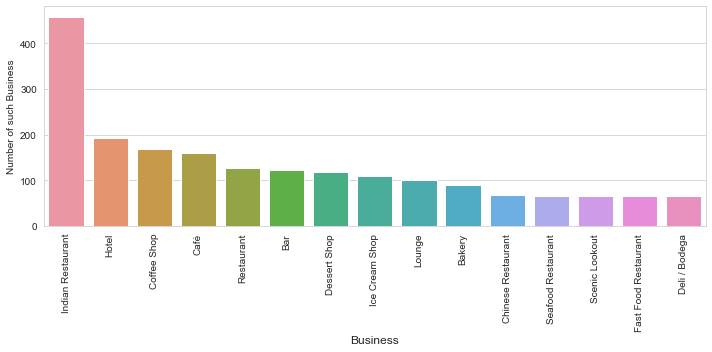

In [77]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.barplot(x=mumbai_nearby_df["Venue Category"].value_counts().head(15).index,y=mumbai_nearby_df["Venue Category"].value_counts().head(15))
plt.xlabel("Business",fontsize=12)
plt.ylabel("Number of such Business")

plt.xticks(rotation=90)
plt.tight_layout(h_pad=0,w_pad=0)
plt.savefig("numberofbuisnesstop10.png")

So in mumbai Indian Restraunt seems to be Very popular for obvious Reason.

In [30]:
mumbai_nearby_df["Venue Category"].value_counts().head(15)

Indian Restaurant       458
Hotel                   193
Coffee Shop             169
Café                    161
Restaurant              127
Bar                     123
Dessert Shop            119
Ice Cream Shop          109
Lounge                  100
Bakery                   91
Chinese Restaurant       69
Seafood Restaurant       67
Scenic Lookout           66
Fast Food Restaurant     66
Deli / Bodega            66
Name: Venue Category, dtype: int64

Lets c in Andheri what is the most common Venue, Well Data says its Hotel mostly because it's near to the Airport.

In [31]:
mumbai_nearby_df[mumbai_nearby_df["Area"]=="Andheri"]["Venue Category"].value_counts().head(10)

Hotel                 12
Indian Restaurant     10
Coffee Shop            7
Café                   5
Ice Cream Shop         4
Pub                    4
Beach                  4
Juice Bar              3
Multiplex              3
Seafood Restaurant     3
Name: Venue Category, dtype: int64

There are 149 unique Venues in mumbai 

In [32]:
mumbai_nearby_df["Venue Category"].nunique()

149

In [33]:
mumbai_nearby_df.groupby("Area").count().head()

,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Area,,,,,,
Andheri,100,100,100,100,100,100
Antop Hill,100,100,100,100,100,100
Bandra,100,100,100,100,100,100
Bhandup,100,100,100,100,100,100
Bhayandar,67,67,67,67,67,67


### Procedding to Clustering 
#### One hot Encoding
* before clustering we will need to convert categorical data set to numerical 
* for that we will use one hot encoding
* later we will group all the dataset with respect to area and take mean of the venue which will give us an insight of what are the top common Venues

In [34]:
one_hot_df = pd.get_dummies(mumbai_nearby_df["Venue Category"])
one_hot_df["Area"] = mumbai_nearby_df["Area"]
one_hot_df.head()

,Airport Service,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Theater,Theme Park,Toy / Game Store,Track,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Shop,Women's Store,Area
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Andheri
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Andheri
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Andheri
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Andheri
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Andheri


In [35]:
filtered_columns = [one_hot_df.columns[-1]]+list(one_hot_df.columns[:-1])
one_hot_df = one_hot_df[filtered_columns]
mumbai_grouped_df =  one_hot_df.groupby("Area").mean().reset_index()
mumbai_grouped_df.head()

,Area,Airport Service,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,...,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Track,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Shop,Women's Store
0,Andheri,0.01,0.01,0.000000,0.0,0.00,0.00,0.01,0.010000,0.00,...,0.00,0.01,0.00,0.0,0.01,0.000000,0.00,0.0,0.000000,0.01
1,Antop Hill,0.00,0.00,0.000000,0.0,0.01,0.01,0.00,0.000000,0.00,...,0.00,0.00,0.00,0.0,0.00,0.000000,0.02,0.0,0.000000,0.00
2,Bandra,0.00,0.00,0.000000,0.0,0.03,0.00,0.00,0.000000,0.01,...,0.00,0.00,0.00,0.0,0.00,0.000000,0.01,0.0,0.000000,0.01
3,Bhandup,0.00,0.00,0.000000,0.0,0.00,0.00,0.00,0.000000,0.00,...,0.01,0.00,0.01,0.0,0.00,0.000000,0.02,0.0,0.000000,0.00
4,Bhayandar,0.00,0.00,0.014925,0.0,0.00,0.00,0.00,0.014925,0.00,...,0.00,0.00,0.00,0.0,0.00,0.029851,0.00,0.0,0.014925,0.00


* We will Fetch top 15 most  common venues of the areas
* later use this data and cluster it in groups 
* then find the most common venue of the cluster to predict which business is likely to bet your money around

In [36]:
def top_15_venue (row,num_of_top_venues=15):
    temp = row.iloc[1:]
    temp_sorted = temp.sort_values(ascending=False)
    
    return temp_sorted.index.values[0:num_of_top_venues]

In [37]:
top_15 =15
position = ["st","nd","rd"]
column=["Area"]
for i in np.arange(top_15):
    if i<=2:
        column.append(f"{i+1}{position[i]} most common venue")
    else:
        column.append(f"{i+1}th most common venue")
top_15_venue_df = pd.DataFrame(columns=column)
top_15_venue_df["Area"]=mumbai_grouped_df["Area"]        



for i in np.arange(mumbai_grouped_df.shape[0]):
    top_15_venue_df.loc[i,1:]=top_15_venue(mumbai_grouped_df.iloc[i,:])



In [38]:
top_15_venue_df.head()

,Area,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,11th most common venue,12th most common venue,13th most common venue,14th most common venue,15th most common venue
0,Andheri,Hotel,Indian Restaurant,Coffee Shop,Café,Ice Cream Shop,Pub,Beach,Chinese Restaurant,Juice Bar,Bar,Bakery,Seafood Restaurant,Multiplex,Restaurant,Sandwich Place
1,Antop Hill,Indian Restaurant,Hotel,Café,Deli / Bodega,Bakery,Bar,Dessert Shop,Lounge,Restaurant,Seafood Restaurant,South Indian Restaurant,Scenic Lookout,Tea Room,Coffee Shop,Chinese Restaurant
2,Bandra,Indian Restaurant,Café,Bar,Bakery,Deli / Bodega,Hotel,Coffee Shop,Asian Restaurant,Dessert Shop,Italian Restaurant,Scenic Lookout,Sandwich Place,Restaurant,Lounge,Salad Place
3,Bhandup,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Lounge,Hotel,Dessert Shop,Ice Cream Shop,Pizza Place,Italian Restaurant,Café,Donut Shop,Diner,Restaurant,Bakery,Snack Place
4,Bhayandar,Indian Restaurant,Restaurant,Sandwich Place,Fast Food Restaurant,Resort,Seafood Restaurant,Ice Cream Shop,Train Station,Café,Bus Station,Food,Flower Shop,Juice Bar,Playground,Mexican Restaurant


In [39]:
top_15_venue_df.shape

(37, 16)

## Clustering 
* with the extracted Dataset we will cluster it in short groups using the perfect k
* We can find k value by elbow method

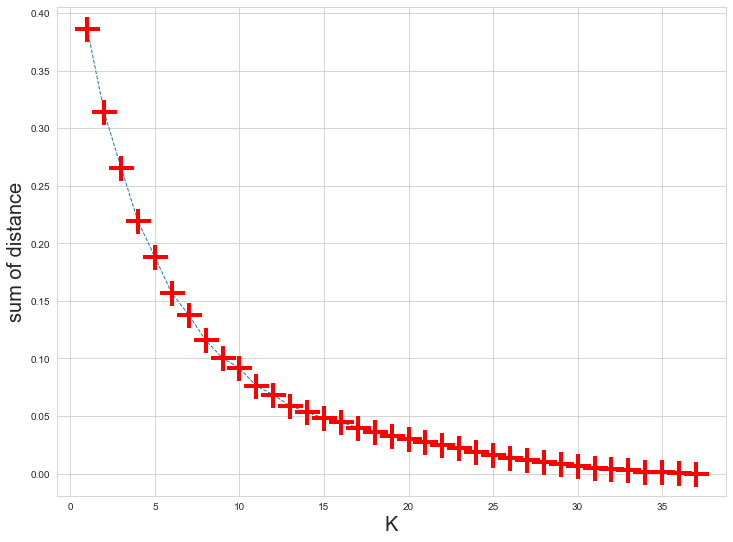

In [82]:
from sklearn.cluster import KMeans
mumbai_training=mumbai_grouped_df.drop("Area",1)

inertia=[]
K=range(1,38)
for k in K:
    km =KMeans(n_clusters=k,random_state=0).fit(mumbai_training)
    inertia.append(km.inertia_)
plt.figure(figsize=(12,9))
plt.plot(K,inertia,marker="+",mec="red",ls="--",lw=1,markersize=25,markeredgewidth=4)
plt.xlabel("K",fontsize=20)
plt.ylabel("sum of distance",fontsize=20)
plt.savefig("elbow.png")

* As we can see the that a perfect k can be in between 6 to 15.
* We will choose K =6 as the data is very less and more cluster might not be acurate 
* later we will join the cluster Labels with our Working Dataset

In [41]:

k=6 #we will take 6 as its better choice 
kmeans = KMeans(n_clusters=k,random_state=0).fit(mumbai_training)
print(kmeans.labels_)

[4 2 4 1 5 3 2 1 0 2 3 0 1 0 3 1 4 2 0 0 3 3 1 4 1 3 1 2 3 2 1 4 0 2 2 1 4]


In [42]:
top_15_venue_df.insert(0,"Cluster Labels",kmeans.labels_)
mumbai_mergerd_df = mumbai_df

mumbai_mergerd_df=mumbai_mergerd_df.join(top_15_venue_df.set_index("Area"),on="Area")

Here is the Combined DataSet
* now lets map this on a Follium map and see what we get 
##### Look closely on to the data of Bhayender which is not a part of mumbai , As cluster usually doesnt have any evaluation test set ,So lets see if Our model distinct BHAYENDER from Mumbai.

In [43]:
mumbai_mergerd_df.head()

,Area,Latitude,Longitude,Cluster Labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,11th most common venue,12th most common venue,13th most common venue,14th most common venue,15th most common venue
0,Andheri,19.118459,72.841763,4,Hotel,Indian Restaurant,Coffee Shop,Café,Ice Cream Shop,Pub,Beach,Chinese Restaurant,Juice Bar,Bar,Bakery,Seafood Restaurant,Multiplex,Restaurant,Sandwich Place
1,Bhayandar,19.307430,72.851840,5,Indian Restaurant,Restaurant,Sandwich Place,Fast Food Restaurant,Resort,Seafood Restaurant,Ice Cream Shop,Train Station,Café,Bus Station,Food,Flower Shop,Juice Bar,Playground,Mexican Restaurant
2,Bandra,19.054370,72.840170,4,Indian Restaurant,Café,Bar,Bakery,Deli / Bodega,Hotel,Coffee Shop,Asian Restaurant,Dessert Shop,Italian Restaurant,Scenic Lookout,Sandwich Place,Restaurant,Lounge,Salad Place
3,Borivali,19.229360,72.857510,3,Indian Restaurant,Restaurant,Fast Food Restaurant,Ice Cream Shop,Coffee Shop,Clothing Store,Pub,Shopping Mall,Multiplex,Chinese Restaurant,Sandwich Place,Resort,Boat or Ferry,Department Store,Dessert Shop
4,Dahisar,19.250030,72.859070,3,Indian Restaurant,Fast Food Restaurant,Restaurant,Ice Cream Shop,Coffee Shop,Pub,Bar,Café,Chinese Restaurant,Gym,Clothing Store,Food Truck,Water Park,Electronics Store,Historic Site


## Maping With Cluster

In [44]:
map_clusters = folium.Map(location=[mum_lat, mum_lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, area, cluster in zip(mumbai_mergerd_df['Latitude'], mumbai_mergerd_df['Longitude'], mumbai_mergerd_df['Area'], mumbai_mergerd_df['Cluster Labels']):
    label = folium.Popup(f"{str(area)} Cluster {str(cluster)}", parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Bingo!!! Look at the cluster 5,the orange point on MAP.

Now as we have the dataset with cluster label , lets bring our Problem statement here
#### Recommend Business and a Location
* for that we will need to make cluster Dictionary
* and later extract the cluster and its top Venue

In [45]:
#this will make a dictionary and segment the dataset based on  cluster
cluster={}
for i in range(6):
    
    cluster["Cluster_"+str(i+1)]=mumbai_mergerd_df.loc[mumbai_mergerd_df["Cluster Labels"]==i][["Area"]+list(mumbai_mergerd_df.columns[4:])]    

#### Below are all the clusters

In [46]:
cluster["Cluster_1"] #extraccting cluster from dictionary

,Area,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,11th most common venue,12th most common venue,13th most common venue,14th most common venue,15th most common venue
28,Colaba,Indian Restaurant,Café,Hotel,Bar,Coffee Shop,Dessert Shop,Ice Cream Shop,Chinese Restaurant,Pizza Place,Diner,Restaurant,Cocktail Bar,Scenic Lookout,Italian Restaurant,Cricket Ground
30,Fort,Indian Restaurant,Café,Hotel,Ice Cream Shop,Bar,Coffee Shop,Dessert Shop,Lounge,Pizza Place,Restaurant,Scenic Lookout,Cocktail Bar,Mughlai Restaurant,Cricket Ground,Bakery
31,Girgaon,Indian Restaurant,Hotel,Café,Restaurant,Ice Cream Shop,Lounge,History Museum,Scenic Lookout,Dessert Shop,Coffee Shop,Juice Bar,Bar,Japanese Restaurant,Middle Eastern Restaurant,Beach
32,Kalbadevi,Indian Restaurant,Café,Ice Cream Shop,Hotel,Restaurant,Bar,Dessert Shop,Scenic Lookout,Coffee Shop,Brewery,Fast Food Restaurant,Beach,Nightclub,Cricket Ground,Monument / Landmark
33,Kamathipura,Indian Restaurant,Hotel,Ice Cream Shop,Restaurant,Café,Scenic Lookout,History Museum,Lounge,Dessert Shop,Coffee Shop,Shopping Mall,Chinese Restaurant,Pizza Place,Cricket Ground,Deli / Bodega
36,Tardeo,Indian Restaurant,Hotel,Café,Ice Cream Shop,Scenic Lookout,Restaurant,Bar,Deli / Bodega,Beach,Pizza Place,Juice Bar,Chinese Restaurant,Seafood Restaurant,Shopping Mall,Coffee Shop


In [47]:
cluster["Cluster_2"]

,Area,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,11th most common venue,12th most common venue,13th most common venue,14th most common venue,15th most common venue
14,Bhandup,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Lounge,Hotel,Dessert Shop,Ice Cream Shop,Pizza Place,Italian Restaurant,Café,Donut Shop,Diner,Restaurant,Bakery,Snack Place
15,Ghatkopar,Hotel,Indian Restaurant,Coffee Shop,Lounge,Bar,Bakery,Dessert Shop,Italian Restaurant,Restaurant,Chinese Restaurant,Garden,Shopping Mall,Diner,Café,Vegetarian / Vegan Restaurant
16,Kanjurmarg,Indian Restaurant,Hotel,Restaurant,Coffee Shop,Dessert Shop,Italian Restaurant,Lounge,Diner,Bar,Café,Shopping Mall,Snack Place,Department Store,Pub,Bakery
17,Kurla,Indian Restaurant,Bar,Hotel,Dessert Shop,Coffee Shop,Café,Lounge,Bakery,Restaurant,Deli / Bodega,Park,Seafood Restaurant,Shopping Mall,Italian Restaurant,Pizza Place
19,Powai,Indian Restaurant,Hotel,Restaurant,Coffee Shop,Lounge,Italian Restaurant,Bakery,Dessert Shop,Ice Cream Shop,Bar,Diner,Beer Garden,Multiplex,Shopping Mall,Gym / Fitness Center
21,Vikhroli,Indian Restaurant,Hotel,Restaurant,Coffee Shop,Lounge,Dessert Shop,Bar,Italian Restaurant,Ice Cream Shop,Bakery,Asian Restaurant,Gym,Vegetarian / Vegan Restaurant,Shopping Mall,Diner
22,Chembur,Indian Restaurant,Hotel,Coffee Shop,Lounge,Dessert Shop,Bar,Café,Restaurant,Vegetarian / Vegan Restaurant,Deli / Bodega,Bakery,Ice Cream Shop,Italian Restaurant,Multiplex,Diner
23,Govandi,Indian Restaurant,Coffee Shop,Hotel,Bar,Restaurant,Dessert Shop,Lounge,Ice Cream Shop,Bakery,Vegetarian / Vegan Restaurant,Café,Garden,Multiplex,Diner,Snack Place
24,Mankhurd,Indian Restaurant,Coffee Shop,Bar,Lounge,Dessert Shop,Restaurant,Ice Cream Shop,Fast Food Restaurant,Hotel,Chinese Restaurant,Shopping Mall,Snack Place,Italian Restaurant,Diner,Garden


In [48]:
cluster["Cluster_3"]

,Area,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,11th most common venue,12th most common venue,13th most common venue,14th most common venue,15th most common venue
7,Juhu,Indian Restaurant,Bakery,Café,Restaurant,Dessert Shop,Deli / Bodega,Coffee Shop,Lounge,Scenic Lookout,Hotel,Seafood Restaurant,Chinese Restaurant,Multiplex,Pub,Park
20,Vidyavihar,Indian Restaurant,Café,Seafood Restaurant,Bakery,Deli / Bodega,Scenic Lookout,Bar,Dessert Shop,Hotel,Restaurant,Coffee Shop,Lounge,Snack Place,Multiplex,Pub
25,Trombay,Indian Restaurant,Dessert Shop,Bar,Ice Cream Shop,Snack Place,Lounge,Café,Coffee Shop,Hotel,Fast Food Restaurant,Restaurant,Garden,Bakery,Asian Restaurant,Italian Restaurant
26,Antop Hill,Indian Restaurant,Hotel,Café,Deli / Bodega,Bakery,Bar,Dessert Shop,Lounge,Restaurant,Seafood Restaurant,South Indian Restaurant,Scenic Lookout,Tea Room,Coffee Shop,Chinese Restaurant
27,Byculla,Indian Restaurant,Café,Restaurant,Ice Cream Shop,Coffee Shop,Dessert Shop,Lounge,Hotel,Scenic Lookout,Bar,Pub,Chinese Restaurant,Seafood Restaurant,Shopping Mall,History Museum
29,Dadar,Indian Restaurant,Café,Bakery,Seafood Restaurant,Restaurant,Scenic Lookout,Deli / Bodega,Dessert Shop,Lounge,Hotel,Coffee Shop,Pub,Chinese Restaurant,Shopping Mall,Snack Place
34,Matunga,Indian Restaurant,Café,Hotel,Deli / Bodega,Seafood Restaurant,Bakery,Coffee Shop,Bar,Restaurant,Lounge,Dessert Shop,Scenic Lookout,South Indian Restaurant,Tea Room,Chinese Restaurant
35,Parel,Indian Restaurant,Scenic Lookout,Hotel,Café,Bar,Restaurant,Snack Place,Coffee Shop,Dessert Shop,Chinese Restaurant,South Indian Restaurant,Ice Cream Shop,History Museum,Deli / Bodega,Seafood Restaurant


In [49]:
cluster["Cluster_4"]

,Area,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,11th most common venue,12th most common venue,13th most common venue,14th most common venue,15th most common venue
3,Borivali,Indian Restaurant,Restaurant,Fast Food Restaurant,Ice Cream Shop,Coffee Shop,Clothing Store,Pub,Shopping Mall,Multiplex,Chinese Restaurant,Sandwich Place,Resort,Boat or Ferry,Department Store,Dessert Shop
4,Dahisar,Indian Restaurant,Fast Food Restaurant,Restaurant,Ice Cream Shop,Coffee Shop,Pub,Bar,Café,Chinese Restaurant,Gym,Clothing Store,Food Truck,Water Park,Electronics Store,Historic Site
5,Goregaon,Indian Restaurant,Café,Multiplex,Hotel,Pub,Coffee Shop,Ice Cream Shop,Bakery,Chinese Restaurant,Clothing Store,Brewery,Pizza Place,Shopping Mall,Donut Shop,Bar
8,Kandivali west,Ice Cream Shop,Coffee Shop,Indian Restaurant,Beach,Multiplex,Fast Food Restaurant,Pub,Restaurant,Shopping Mall,Dessert Shop,Clothing Store,Hotel,Sandwich Place,Café,Scenic Lookout
9,Kandivali east,Indian Restaurant,Ice Cream Shop,Coffee Shop,Fast Food Restaurant,Restaurant,Chinese Restaurant,Pub,Clothing Store,Multiplex,Shopping Mall,Snack Place,Mexican Restaurant,Dessert Shop,Hotel,Donut Shop
11,Malad,Coffee Shop,Ice Cream Shop,Multiplex,Pub,Fast Food Restaurant,Restaurant,Clothing Store,Shopping Mall,Pizza Place,Beach,Bakery,Juice Bar,Chinese Restaurant,Indian Restaurant,Hotel
18,Mulund,Indian Restaurant,Coffee Shop,Café,Fast Food Restaurant,Dessert Shop,Pizza Place,Hotel,Snack Place,Gym / Fitness Center,Pub,Scenic Lookout,Italian Restaurant,Donut Shop,Department Store,Lounge


In [50]:
cluster["Cluster_5"]

,Area,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,11th most common venue,12th most common venue,13th most common venue,14th most common venue,15th most common venue
0,Andheri,Hotel,Indian Restaurant,Coffee Shop,Café,Ice Cream Shop,Pub,Beach,Chinese Restaurant,Juice Bar,Bar,Bakery,Seafood Restaurant,Multiplex,Restaurant,Sandwich Place
2,Bandra,Indian Restaurant,Café,Bar,Bakery,Deli / Bodega,Hotel,Coffee Shop,Asian Restaurant,Dessert Shop,Italian Restaurant,Scenic Lookout,Sandwich Place,Restaurant,Lounge,Salad Place
6,Jogeshwari,Indian Restaurant,Hotel,Coffee Shop,Café,Multiplex,Pub,Seafood Restaurant,Brewery,Chinese Restaurant,Juice Bar,Bakery,Bar,Pizza Place,Fast Food Restaurant,Restaurant
10,Khar,Indian Restaurant,Café,Hotel,Bar,Bakery,Deli / Bodega,Coffee Shop,Lounge,Seafood Restaurant,Dessert Shop,Asian Restaurant,Chinese Restaurant,Salad Place,Park,Pizza Place
12,Santacruz,Indian Restaurant,Hotel,Bar,Coffee Shop,Seafood Restaurant,Café,Bakery,Deli / Bodega,Ice Cream Shop,Lounge,Park,Gym / Fitness Center,Tea Room,Sandwich Place,Scenic Lookout
13,Vile Parle,Hotel,Indian Restaurant,Coffee Shop,Café,Seafood Restaurant,Bar,Ice Cream Shop,Deli / Bodega,Sandwich Place,Dessert Shop,Cocktail Bar,Multiplex,Juice Bar,Lounge,Beach


In [51]:
cluster["Cluster_6"]

,Area,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,11th most common venue,12th most common venue,13th most common venue,14th most common venue,15th most common venue
1,Bhayandar,Indian Restaurant,Restaurant,Sandwich Place,Fast Food Restaurant,Resort,Seafood Restaurant,Ice Cream Shop,Train Station,Café,Bus Station,Food,Flower Shop,Juice Bar,Playground,Mexican Restaurant


Here we are collecting all the Venue and later we will extract list of all venues in a cluster

In [52]:

col=['1st most common venue','2nd most common venue','3rd most common venue','4th most common venue','5th most common venue','6th most common venue','7th most common venue','8th most common venue','9th most common venue','10th most common venue']
list_ven ={}
# so basically this function will 
# extract all the list venues of a clusters in a single dict
def best_buisness_in_locatlity (dictionary):
    col=['1st most common venue','2nd most common venue','3rd most common venue','4th most common venue','5th most common venue','6th most common venue','7th most common venue','8th most common venue','9th most common venue','10th most common venue']  
    for key in dictionary:
        lis=[]
        for columnname in col:
            
            vl = dictionary[key][columnname].tolist()
            for li in vl:
                lis.append(li)
                
                
        list_ven[key]= lis   
    return list_ven   

In [53]:
best_buisness_in_locatlity(dictionary=cluster)

{'Cluster_1': ['Indian Restaurant',
  'Indian Restaurant',
  'Indian Restaurant',
  'Indian Restaurant',
  'Indian Restaurant',
  'Indian Restaurant',
  'Café',
  'Café',
  'Hotel',
  'Café',
  'Hotel',
  'Hotel',
  'Hotel',
  'Hotel',
  'Café',
  'Ice Cream Shop',
  'Ice Cream Shop',
  'Café',
  'Bar',
  'Ice Cream Shop',
  'Restaurant',
  'Hotel',
  'Restaurant',
  'Ice Cream Shop',
  'Coffee Shop',
  'Bar',
  'Ice Cream Shop',
  'Restaurant',
  'Café',
  'Scenic Lookout',
  'Dessert Shop',
  'Coffee Shop',
  'Lounge',
  'Bar',
  'Scenic Lookout',
  'Restaurant',
  'Ice Cream Shop',
  'Dessert Shop',
  'History Museum',
  'Dessert Shop',
  'History Museum',
  'Bar',
  'Chinese Restaurant',
  'Lounge',
  'Scenic Lookout',
  'Scenic Lookout',
  'Lounge',
  'Deli / Bodega',
  'Pizza Place',
  'Pizza Place',
  'Dessert Shop',
  'Coffee Shop',
  'Dessert Shop',
  'Beach',
  'Diner',
  'Restaurant',
  'Coffee Shop',
  'Brewery',
  'Coffee Shop',
  'Pizza Place'],
 'Cluster_2': ['Indian Res

now as we have all the cluster and the list of venues of a cluster we will find out the most value counts of a cluster

In [54]:
df_ven_cluster=[]
top_10_ven_in_cluster={}
for i in range(6):
    df_ven_cluster.append(pd.DataFrame(list_ven[f"Cluster_{i+1}"],columns=["cluster_venues"]))
    top_10_ven_in_cluster[f"Cluster_{i+1}_venues"]=df_ven_cluster[i]["cluster_venues"].value_counts().head(15)

## Exploratory Data Analysis

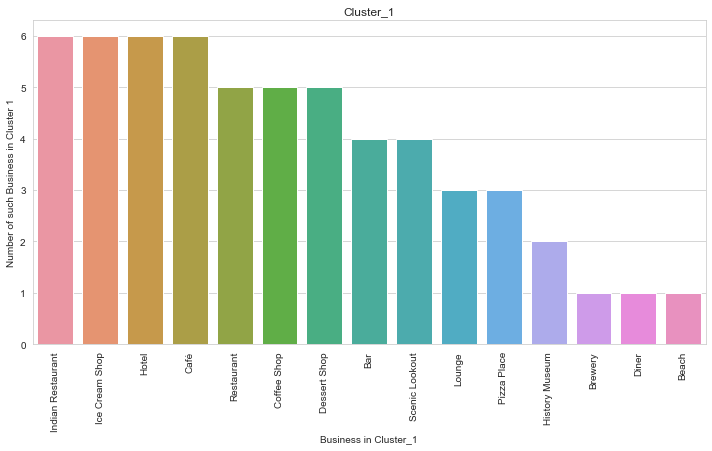

In [55]:
X=top_10_ven_in_cluster["Cluster_1_venues"].index
Y=top_10_ven_in_cluster["Cluster_1_venues"]
plt.figure(figsize=(10,6))
sns.barplot(x=top_10_ven_in_cluster["Cluster_1_venues"].index,y=top_10_ven_in_cluster["Cluster_1_venues"])
plt.xticks(rotation=90)
plt.tight_layout(h_pad=0,w_pad=0)
plt.xlabel("Business in Cluster_1")
plt.ylabel("Number of such Business in Cluster 1")
plt.title("Cluster_1")
plt.savefig("Cluster_1.png")

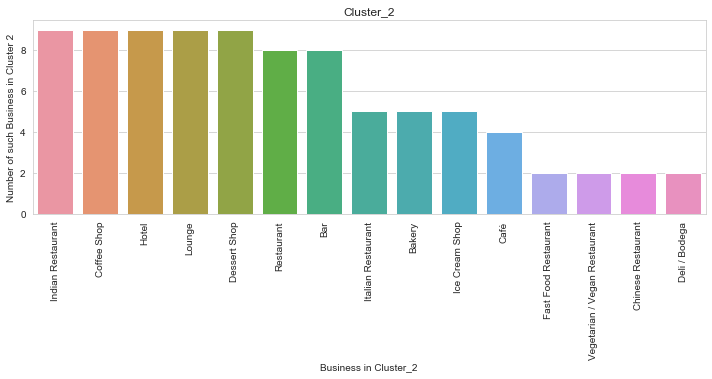

In [56]:
X=top_10_ven_in_cluster["Cluster_2_venues"].index
Y=top_10_ven_in_cluster["Cluster_2_venues"]
plt.figure(figsize=(10,5))
sns.barplot(x=top_10_ven_in_cluster["Cluster_2_venues"].index,y=top_10_ven_in_cluster["Cluster_2_venues"])
plt.xticks(rotation=90)
plt.tight_layout(h_pad=0,w_pad=0)
plt.xlabel("Business in Cluster_2")
plt.ylabel("Number of such Business in Cluster 2")
plt.title("Cluster_2")
plt.savefig("Cluster_2.png")

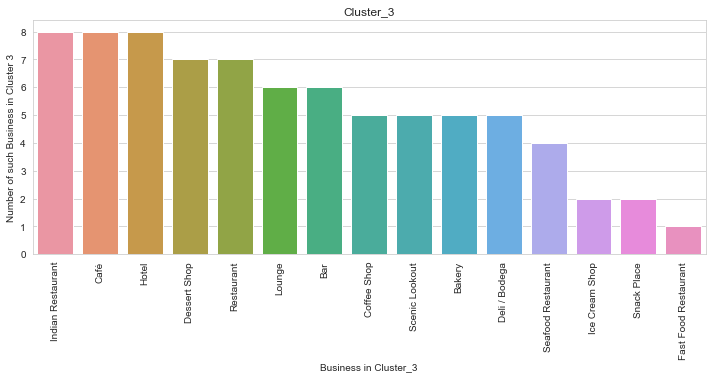

In [57]:
X=top_10_ven_in_cluster["Cluster_3_venues"].index
Y=top_10_ven_in_cluster["Cluster_3_venues"]
plt.figure(figsize=(10,5))
sns.barplot(x=top_10_ven_in_cluster["Cluster_3_venues"].index,y=top_10_ven_in_cluster["Cluster_3_venues"])
plt.xticks(rotation=90)
plt.tight_layout(h_pad=0,w_pad=0)
plt.xlabel("Business in Cluster_3")
plt.ylabel("Number of such Business in Cluster 3")
plt.title("Cluster_3")
plt.savefig("Cluster_3.png")

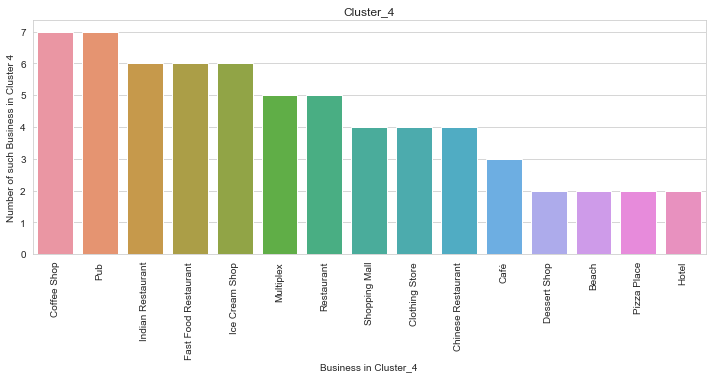

In [58]:
X=top_10_ven_in_cluster["Cluster_4_venues"].index
Y=top_10_ven_in_cluster["Cluster_4_venues"]
plt.figure(figsize=(10,5))
sns.barplot(x=top_10_ven_in_cluster["Cluster_4_venues"].index,y=top_10_ven_in_cluster["Cluster_4_venues"])
plt.xticks(rotation=90)
plt.tight_layout(h_pad=0,w_pad=0)
plt.xlabel("Business in Cluster_4")
plt.ylabel("Number of such Business in Cluster 4")
plt.title("Cluster_4")
plt.savefig("Cluster_4.png")

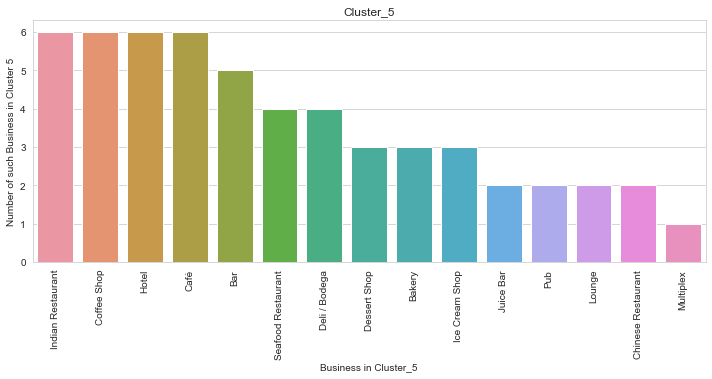

In [59]:
X=top_10_ven_in_cluster["Cluster_5_venues"].index
Y=top_10_ven_in_cluster["Cluster_5_venues"]
plt.figure(figsize=(10,5))
sns.barplot(x=top_10_ven_in_cluster["Cluster_5_venues"].index,y=top_10_ven_in_cluster["Cluster_5_venues"])
plt.xticks(rotation=90)
plt.tight_layout(h_pad=0,w_pad=0)
plt.xlabel("Business in Cluster_5")
plt.ylabel("Number of such Business in Cluster 5")
plt.title("Cluster_5")
plt.savefig("Cluster_5.png")

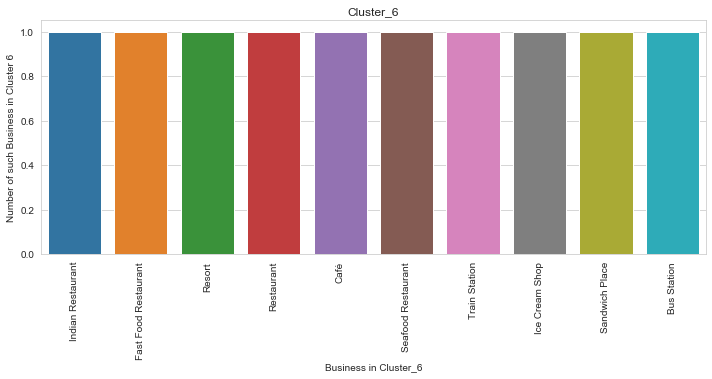

In [60]:
X=top_10_ven_in_cluster["Cluster_6_venues"].index
Y=top_10_ven_in_cluster["Cluster_6_venues"]
plt.figure(figsize=(10,5))
sns.barplot(x=top_10_ven_in_cluster["Cluster_6_venues"].index,y=top_10_ven_in_cluster["Cluster_6_venues"])
plt.xticks(rotation=90)
plt.tight_layout(h_pad=0,w_pad=0)
plt.xlabel("Business in Cluster_6")
plt.ylabel("Number of such Business in Cluster 6")
plt.title("Cluster_6")
plt.savefig("Cluster_6.png")

### So lets say we are looking to open a new buisness in malad what would be the right choice 

In [61]:
#First we will Find in which cluster is malad situated
mumbai_mergerd_df[mumbai_mergerd_df["Area"]=="Malad"][""]


,Area,Latitude,Longitude,Cluster Labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,11th most common venue,12th most common venue,13th most common venue,14th most common venue,15th most common venue
11,Malad,19.18655,72.84842,3,Coffee Shop,Ice Cream Shop,Multiplex,Pub,Fast Food Restaurant,Restaurant,Clothing Store,Shopping Mall,Pizza Place,Beach,Bakery,Juice Bar,Chinese Restaurant,Indian Restaurant,Hotel


Cluster 3 that is 3+1

In [62]:
cluster["Cluster_4"]

,Area,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,11th most common venue,12th most common venue,13th most common venue,14th most common venue,15th most common venue
3,Borivali,Indian Restaurant,Restaurant,Fast Food Restaurant,Ice Cream Shop,Coffee Shop,Clothing Store,Pub,Shopping Mall,Multiplex,Chinese Restaurant,Sandwich Place,Resort,Boat or Ferry,Department Store,Dessert Shop
4,Dahisar,Indian Restaurant,Fast Food Restaurant,Restaurant,Ice Cream Shop,Coffee Shop,Pub,Bar,Café,Chinese Restaurant,Gym,Clothing Store,Food Truck,Water Park,Electronics Store,Historic Site
5,Goregaon,Indian Restaurant,Café,Multiplex,Hotel,Pub,Coffee Shop,Ice Cream Shop,Bakery,Chinese Restaurant,Clothing Store,Brewery,Pizza Place,Shopping Mall,Donut Shop,Bar
8,Kandivali west,Ice Cream Shop,Coffee Shop,Indian Restaurant,Beach,Multiplex,Fast Food Restaurant,Pub,Restaurant,Shopping Mall,Dessert Shop,Clothing Store,Hotel,Sandwich Place,Café,Scenic Lookout
9,Kandivali east,Indian Restaurant,Ice Cream Shop,Coffee Shop,Fast Food Restaurant,Restaurant,Chinese Restaurant,Pub,Clothing Store,Multiplex,Shopping Mall,Snack Place,Mexican Restaurant,Dessert Shop,Hotel,Donut Shop
11,Malad,Coffee Shop,Ice Cream Shop,Multiplex,Pub,Fast Food Restaurant,Restaurant,Clothing Store,Shopping Mall,Pizza Place,Beach,Bakery,Juice Bar,Chinese Restaurant,Indian Restaurant,Hotel
18,Mulund,Indian Restaurant,Coffee Shop,Café,Fast Food Restaurant,Dessert Shop,Pizza Place,Hotel,Snack Place,Gym / Fitness Center,Pub,Scenic Lookout,Italian Restaurant,Donut Shop,Department Store,Lounge


So lets Find out which business is most common in this Cluster

In [63]:
top_10_ven_in_cluster["Cluster_4_venues"]

Coffee Shop             7
Pub                     7
Indian Restaurant       6
Fast Food Restaurant    6
Ice Cream Shop          6
Multiplex               5
Restaurant              5
Shopping Mall           4
Clothing Store          4
Chinese Restaurant      4
Café                    3
Dessert Shop            2
Beach                   2
Pizza Place             2
Hotel                   2
Name: cluster_venues, dtype: int64

Pub seems to be quite catchy in this cluster or areas coffee shop is because may be people chill around here 

Although their is no evaluation as such but personally i live here and i m not surprised by this data

#### Now lets see which Business we can bet our money upon and where
* lets now quick compare all over dataframe of mumbai's venues and this cluster venues 

In [64]:
mumbai_nearby_df["Venue Category"].value_counts().head(15)

Indian Restaurant       458
Hotel                   193
Coffee Shop             169
Café                    161
Restaurant              127
Bar                     123
Dessert Shop            119
Ice Cream Shop          109
Lounge                  100
Bakery                   91
Chinese Restaurant       69
Seafood Restaurant       67
Scenic Lookout           66
Fast Food Restaurant     66
Deli / Bodega            66
Name: Venue Category, dtype: int64

We Can invest in following Categories which can intrest people of Malad
* Pub
* Coffee Shop
* Ice cream shop
* Indian Restraunt
* Hotel
* fast food Restraunt
* Multiplex
* Malls

The Above Recomendation is based on the common venues in the top 6 of malad, cluster 3 and mumbai

## Making a wordcloud

In [65]:
tostr =list(mumbai_nearby_df["Venue Category"]) #list of all string

In [66]:
li=[]
for i in tostr:
    li.append(i.replace(" ","_")) #avoiding spacings

In [67]:
from wordcloud import WordCloud ,STOPWORDS,ImageColorGenerator# importing for wordcloud



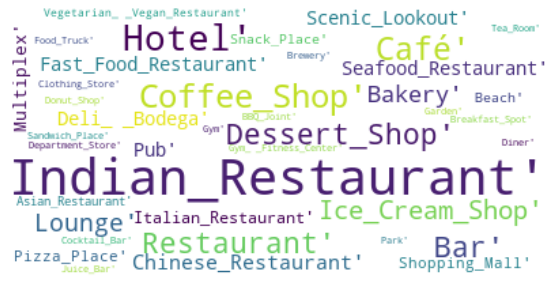

In [87]:
wordcloud = WordCloud(max_font_size=40,max_words=40
                      ,background_color="white").generate(str(li))
plt.figure(figsize=(12,5))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

The wordcloud shows the category of business most common  in mumbai

In [88]:
wordcloud.to_file("top_venues.png")

## Results and Discussion <a name="results"></a>


#### What we gain and got from this analysis
* We got a good insight of businesses for customers that has flooded the Mumbai's market.
* Their are lot of unique Businesses one can opt for.
* if a person is interested to invest in any business one could rely on this analysis
* although if a person has any paricular business he wants to open as such, this analysis can be used too, like opening Hotel will be more profitable in Andheri(Airport) than in Malad.

well their is no evaluation as such for cluster model in real world but as we can see our cluster was able to distinguish between south mumbai, north mumbai ,central, and harbour.

#### How did we analysed best Business to invest in Malad 
* We took top 15 Venues in Mumbai , Then we compared it with Cluster 4's top 15 Venues.
    * Here we saw that in cluster 4 Hotel was in the tail, but hotel in Mumbai's list was on 2nd,so we Recommended Hotel as it will have low competition and also there are very less amount such buisness in this cluster.
    * then we compared all this top 15 venues with Malad's and every other top 15 venues and it seems Its good to invest in Pub and Fast food Restraunt.
* Similarly we Can compare this three top 15 venues to get any other business in a location, cluster to invest our money upon

#### Future of this project
* We can use any dataset , for a state, or for whole country
* We can go further and use foursquare api to locate best location to rent house in a budget.
* althogh this is a project but after deploying it can be very user friendly
* we can add other dataset as such for greater flexiblity.
* we can predict the buisness further by using dataset of that category and predicting our case.


## Conclusion <a name="conclusion"></a>

Purpose of this project was to recommend business and a location for the business to boost start the business by investing with some sort of assurity that if the business is compatible or not in the given location.

Final statements will be madde by the Stakeholders